In [1]:
from utils.units import basis, u
from utils.units.sympy_helpers import split_unit_form as split_unit
from sympy.abc import s

km = 11.8740 * (u.rad/u.s)/(u.V)  # ?
vpp = 10*u.V
ve = 60*u.V
ks = 4*u.V/(750*u.rad/u.s)
tm = 0.003213*u.s

ts_max = 20*u.ms
mp_max = 5*u.percent

gp = ve/vpp * km/(tm*s+1)
split_unit(gp)

(radian/(second*volt))*(71.244/(0.003213*second*s + 1))

In [2]:
nu = basis()
nu

NumericalBasis(mapper=QuantityMapper(salt=742822449304830392), proxy_system=<UnitSystem: (meter, kilogram, second, ampere, mole, candela, kelvin)>)

In [3]:
from utils.units.sympy_helpers import without_units

def pprint(obj):
    print(obj)
    return obj

without_units(gp, lambda get_dummy, expr: expr.subs(s, s*1/get_dummy(u.s)))

71.244*radian/(second*volt*(0.003213*s + 1))

In [4]:
from utils.ctrlsys import s2tf, pole_specs, z_map
import control.matlab as m
import numpy as np
z = m.tf("z")

to_tf = lambda expr: s2tf(nu.to_numeric(expr, as_expr=True), s)
u2symb = lambda unit, value: split_unit(nu.to_symb(unit, value))

dt = ts_max/15
gp_tf = to_tf(gp)
gp_dtf = m.c2d(gp_tf, nu[dt])
gs_tf = (z/z).minreal()*nu[ks]
gsmp_dtf = 1/z
dp_s = pole_specs(nu[ts_max], nu[mp_max])
dp = [z_map(s, nu[dt]) for s in dp_s]
gc_poles = np.exp(np.asarray([0])*nu[dt])
gclnc_dtf = m.feedback(gp_dtf, gs_tf)
gls = {
    "planta": gp_dtf,
    "sensor": gs_tf,
    "muestreador": gsmp_dtf,
}

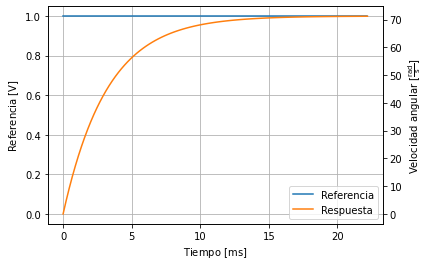

In [5]:
from utils.mpl import io_axes, nu_twinx_axes
from utils.ctrlsys import step, zoh_stairs
my_step = lambda sys: lambda T=None: reversed(m.step(sys, T=T))

fig, (ax_e, ax_r), get_color, post = io_axes()
nu_twinx_axes(nu, ax_e, ax_r,
    ("Tiempo", u.ms),
    ("Referencia", u.V),
    ("Velocidad angular", u.rad/u.s)
)

t, (ref, resp) = step(my_step(gp_tf), ampl=nu[u.V])
ax_e.plot(t, ref, c=get_color(), label="Referencia")
ax_r.plot(t, resp, c=get_color(), label="Respuesta")

ax_e.grid()
post(gp_tf.dcgain(), "lower right")

In [6]:
def with_override(f, **override_kwargs):
    def partial(*args, **kwargs):
        return f(*args, **(kwargs | override_kwargs))
    return partial

def with_default(f, **default_kwargs):
    def partial(*args, **kwargs):
        return f(*args, **(default_kwargs | kwargs))
    return partial


In [7]:
from utils.ctrlsys import zp_plot

def scatter_syss(syss, sp, sz):
    for name, sys in syss.items():
        sp(sys.pole(), label=f"Polos de {name}")
        sz(sys.zero(), label=f"Ceros de {name}")

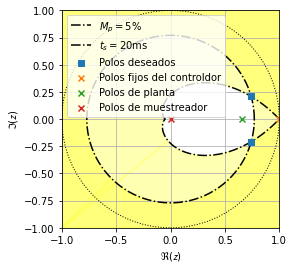

In [8]:
%matplotlib inline
from utils.mpl import latex_notext as lt
import numpy as np

fig, ax, (
    (add_ucircle, add_ts_max, add_mp_max),
    (scatter_poles, scatter_zeros)) = zp_plot()
ax.set_ylim((-1, 1))
ax.set_xlim((-1, 1))
ax.grid()

scatter_poles(dp, label="Polos deseados", marker='s')
scatter_poles(gc_poles, label="Polos fijos del controldor")
scatter_syss(gls, scatter_poles, scatter_zeros)

ax.set_axisbelow(True)
add_ucircle()
add_mp_max(nu[mp_max], label=f"$M_p={lt(mp_max)}$")
add_ts_max(nu[ts_max], nu[dt], label=f"$t_s={lt(ts_max)}$")

#fig.legend(loc="upper right", bbox_to_anchor=(1.1, .87))
ax.legend()
ax.set_aspect(1)

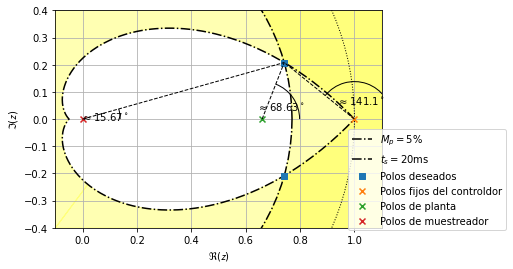

In [9]:
from utils.mpl.annotations import annotate_angle
from utils.math import angle_between, reim
from utils.misc import concat

fig, ax, (
    (add_ucircle, add_ts_max, add_mp_max),
    (scatter_poles, scatter_zeros)) = zp_plot()
ax.set_ylim((-.4, .4))
ax.set_xlim((-.1, 1.1))
ax.grid()

def rloc_angle(p, dp):
    annotate_angle(reim(p), reim(p+1), reim(dp), ax,
        lambda *args: "$\\approx {}$".format(
            lt(nu.to_symb(u.deg, angle_between(*args)).n(4))))
    ax.plot([p.real, dp.real], [p.imag, dp.imag],
        linestyle="--", c='k', linewidth=1)

for sys in gls.values():
    for point in concat(sys.pole(), sys.zero()):
        rloc_angle(point, dp[1])
rloc_angle(gc_poles[0], dp[1])

scatter_poles(dp, label="Polos deseados", marker='s')
scatter_poles(gc_poles, label="Polos fijos del controldor")
scatter_syss(gls, scatter_poles, scatter_zeros)

ax.set_axisbelow(True)
add_ucircle()
add_mp_max(nu[mp_max], label=f"$M_p={lt(mp_max)}$")
add_ts_max(nu[ts_max], nu[dt], label=f"$t_s={lt(ts_max)}$")

fig.legend(loc="lower left", bbox_to_anchor=(.8, .1))
ax.set_aspect(1)

In [10]:
from utils.ctrlsys import phase_def, mag_def

In [11]:
import math
from utils.misc import concat
from itertools import chain
lchain = lambda *iters: list(chain(*iters))
def angle_between_c(*args):
    return angle_between(*map(reim, args))

def pprint(obj):
    print(obj)
    return obj

a = -dp[1].imag/math.tan(
        phase_def(dp[1],
            lchain(*[sys.pole() for sys in gls.values()], gc_poles),
            lchain(*[sys.zero() for sys in gls.values()]))
        ) + dp[1].real
gc_zeros = [a]
gc_zeros

[0.5367953555794696]

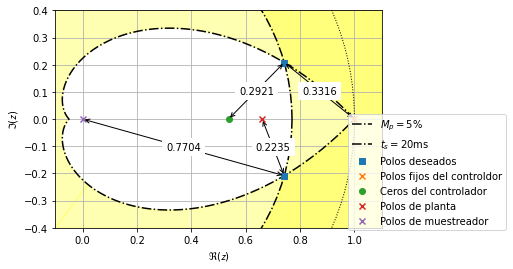

In [12]:
from utils.mpl.annotations import annotate_length
from utils.math import dist

fig, ax, (
    (add_ucircle, add_ts_max, add_mp_max),
    (scatter_poles, scatter_zeros)) = zp_plot()
ax.set_ylim((-.4, .4))
ax.set_xlim((-.1, 1.1))
ax.grid()

def rloc_mag(p, dp, prop=.5):
    p, dp = map(reim, [p, dp])
    annotate_length(ax, p, dp, prop,
        lambda p, dp: f"{dist(p, dp):.04f}")
    
for sys in gls.values():
    for point in concat(sys.pole(), sys.zero()):
        rloc_mag(point, dp[0])
rloc_mag(gc_poles[0], dp[1])
rloc_mag(gc_zeros[0], dp[1])
scatter_poles(dp, label="Polos deseados", marker="s")
scatter_poles(gc_poles, label="Polos fijos del controldor")
scatter_zeros(gc_zeros, label="Ceros del controlador")
scatter_syss(gls, scatter_poles, scatter_zeros)

ax.set_axisbelow(True)
add_ucircle()
add_mp_max(nu[mp_max], label=f"$M_p={lt(mp_max)}$")
add_ts_max(nu[ts_max], nu[dt], label=f"$t_s={lt(ts_max)}$")

fig.legend(loc="lower left", bbox_to_anchor=(.8, .1))
ax.set_aspect(1)

In [13]:
kc = mag_def(
    dp[1],
    lchain(*[sys.pole() for sys in gls.values()], gc_poles),
    lchain(*[sys.zero() for sys in gls.values()], gc_zeros)
) / np.prod([m.tf2zpk(sys.num[0][0], sys.den[0][0])[2] for sys in gls.values()])
#kc=1

gc_dtf = kc*(z-a)/(z-1)
gcl_dtf = m.feedback(gsmp_dtf * gc_dtf * gp_dtf, gs_tf)
kc

1.5144812393290148

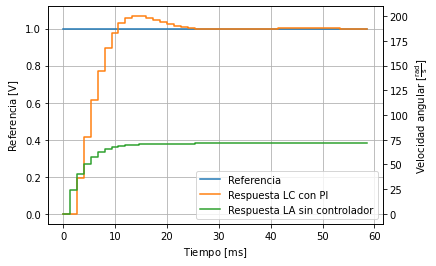

In [14]:
%matplotlib inline
from utils.mpl import io_axes, nu_twinx_axes
from utils.ctrlsys import step, zoh_stairs
my_step = lambda sys: lambda T=None: reversed(m.step(sys, T=T))

fig, (ax_e, ax_r), get_color, post = io_axes()
nu_twinx_axes(nu, ax_e, ax_r,
    ("Tiempo", u.ms),
    ("Referencia", u.V),
    ("Velocidad angular", u.rad/u.s)
)

t = np.arange(0, nu[ts_max*3], nu[dt])
_, (ref, resp) = step(my_step(gcl_dtf), ampl=nu[u.V], t=t)
_, (_, resp_nc) = step(my_step(gp_dtf), ampl=nu[u.V], t=t)
ax_e.plot(t, ref, c=get_color(), label="Referencia")
ax_r.plot(*zoh_stairs(t, resp), c=get_color(), label="Respuesta LC con PI")
ax_r.plot(*zoh_stairs(t, resp_nc), c=get_color(), label="Respuesta LA sin controlador")

ax_e.grid()
post(gcl_dtf.dcgain(), "lower right")

In [15]:
from utils.misc import repr_aligned
from utils.ctrl import nu_stepinfo

perf = nu_stepinfo(nu, u.ms, u.rad/u.s, m.stepinfo(gcl_dtf), ampl=nu[u.V])

print(repr_aligned(
    {k: v.n(4) for k, v in perf.items()}))

{
    'RiseTime':         6.667*millisecond
    'SettlingTime':     21.33*millisecond
    'SettlingMin':      183.0*radian/second
    'SettlingMax':      199.9*radian/second
    'Overshoot':        6.613*percent
    'Undershoot':       0
    'Peak':             199.9*radian/second
    'PeakTime':         13.33*millisecond
    'SteadyStateValue': 187.5*radian/second
}


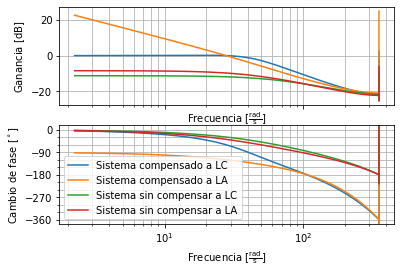

In [16]:
from utils.mpl import set_datalim
from utils.mpl import nu_sharex_axes
from utils.ctrl import bode_axes

fig, (ax_gain, ax_phase), add_bode_, add_deg_locator = bode_axes()

add_bode = lambda sys, **kwargs: add_bode_(sys, deg=False, dB=True, **kwargs)

add_bode(gcl_dtf * gs_tf, label="Sistema compensado a LC")
add_bode(gsmp_dtf * gc_dtf * gp_dtf * gs_tf, label="Sistema compensado a LA")
add_bode(gclnc_dtf * gs_tf, label="Sistema sin compensar a LC")
add_bode(gp_dtf * gs_tf, label="Sistema sin compensar a LA")

add_deg_locator(90)

nu_sharex_axes(nu, ax_phase, ax_gain,
    ("Frecuencia", u.rad/u.s),
    ("Cambio de fase", u.deg),
    ("Ganancia", 1),
    y2_in_db=True)

ax_gain.grid(which='both')
ax_phase.grid(which='both')
set_datalim(ax_phase, y=(-nu[360*u.deg], 0))

ax_phase.legend(); None


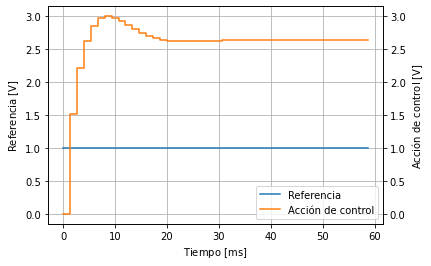

In [17]:
from utils.mpl import io_axes, nu_twinx_axes
from utils.ctrlsys import step, zoh_stairs
my_step = lambda sys: lambda T=None: reversed(m.step(sys, T=T))

fig, (ax_e, ax_r), get_color, post = io_axes()
nu_twinx_axes(nu, ax_e, ax_r,
    ("Tiempo", u.ms),
    ("Referencia", u.V),
    ("Acción de control", u.V)
)

t = np.arange(0, nu[ts_max*3], nu[dt])
_, (ref, resp) = step(my_step(m.feedback(gsmp_dtf * gc_dtf, gs_tf * gp_dtf)), ampl=nu[u.V], t=t)
ax_e.plot(t, ref, c=get_color(), label="Referencia")
ax_r.plot(*zoh_stairs(t, resp), c=get_color(), label="Acción de control")

ax_e.grid()
post(1, "lower right")